Seems like we're approaching a threshold of performance with just plain dataset -- which is around 0.96 -- without any image augmentations. Let's work on playing with our dataset/dataloaders in order to incorporate some image augmentations

In [88]:
from fastai.vision.all import *
from torch.utils.data import Dataset
import albumentations as A
from sklearn.model_selection import train_test_split

In [3]:
path = Path('/home/azaidi/Desktop/kaggle/seti_2021')
Path.BASE_PATH = path
path.ls()

(#14) [Path('kfold.ipynb'),Path('res50.ipynb'),Path('data'),Path('kf_sesresnext.ipynb'),Path('models'),Path('.git'),Path('Untitled.ipynb'),Path('initial.ipynb'),Path('.gitignore'),Path('.ipynb_checkpoints')...]

In [4]:
train_df = pd.read_csv(path/'data/train_labels.csv')
sub_df = pd.read_csv(path/'data/sample_submission.csv')
train_df.shape

(50165, 2)

In [5]:
data_path = path/'data'
train_df['path'] = train_df['id'].apply(lambda x: str(data_path/'train'/x[0]/x)+'.npy')

In [6]:
train_df.head(1)

,id,target,path
0,00034abb3629,0,/home/azaidi/Desktop/kaggle/seti_2021/data/train/0/00034abb3629.npy


In [50]:
class SetiDS(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        target = self.df.iloc[idx].target
        path = self.df.iloc[idx].path
        
        #the samples are all a 6x273x256 matrix
        x = np.load(path).astype(np.float32)
        x = np.vstack(x) #gives you a 1638x256 matrix
        x = x.transpose((1,0)) # 256x1638 now
        
        return x, target

In [51]:
ds = SetiDS(train_df)
len(ds)

50165

In [53]:
ds[0][0].shape, ds[0][1]

((256, 1638), 0)

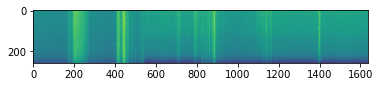

In [55]:
plt.imshow(ds[0][0]);

We'll use a simple, arbitrary transform, on it's own to showcase that it's working

In [68]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5)
])

In [69]:
transform(image=ds[0][0])['image'].shape

(256, 1638)

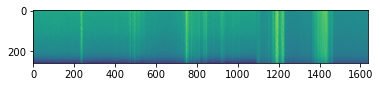

In [70]:
plt.imshow(transform(image=ds[0][0])['image']);

You can see the same image flipped on it's horizontal axis

In [72]:
transform = A.Compose([
    A.RandomCrop(width=128, height=128),
    A.HorizontalFlip(p=0.5)
])

In [75]:
class SetiDS(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        target = self.df.iloc[idx].target
        path = self.df.iloc[idx].path
        
        #the samples are all a 6x273x256 matrix
        x = np.load(path).astype(np.float32)
        x = np.vstack(x) #gives you a 1638x256 matrix
        x = x.transpose((1,0)) # 256x1638 now
        
        if self.transforms:
            x = self.transforms(image=x)['image']
        
        return x, target

In [76]:
ds = SetiDS(train_df, transform)
ds[0][0].shape

(128, 128)

Looks like it works! Just double check below that we can still get our data without transforms if we'd like

In [78]:
ds = SetiDS(train_df)
ds[0][0].shape

(256, 1638)

Let's keep the entire sample size and only use horizontal and vertical flips

In [79]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

In [81]:
class SetiDS(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        target = self.df.iloc[idx].target
        path = self.df.iloc[idx].path
        
        #the samples are all a 6x273x256 matrix
        x = np.load(path).astype(np.float32)
        x = np.vstack(x) #gives you a 1638x256 matrix
        x = x.transpose((1,0)) # 256x1638 now
        
        if self.transforms:
            x = self.transforms(image=x)['image']
        
        x = torch.tensor(x).float().unsqueeze(0)
        
        return x, torch.tensor(target)

In [85]:
ds = SetiDS(train_df)
ds[0][0].shape, ds[0][1]

(torch.Size([1, 256, 1638]), tensor(0))

In [89]:
t_df, v_df = train_test_split(train_df, test_size=0.2)

In [90]:
t_ds = SetiDS(t_df)
v_ds = SetiDS(v_df)

In [91]:
bs=32
train_dl = torch.utils.data.DataLoader(t_ds, 
                    batch_size=bs,num_workers=8)
valid_dl = torch.utils.data.DataLoader(v_ds,
                    batch_size=bs,num_workers=8)
dls = DataLoaders(train_dl, valid_dl)

Let's make sure we can cast to a dataloader for our training

In [95]:
batch = next(iter(train_dl))
len(batch)

2

In [98]:
batch[0].shape, batch[1].shape

(torch.Size([32, 1, 256, 1638]), torch.Size([32]))

How's the image looking?

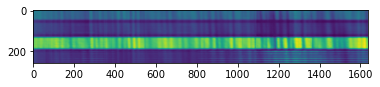

In [101]:
plt.imshow(batch[0][0].squeeze(0).numpy());

Looks like we have a simple pipeline to extract our images -- we can resize the array inside of our transform function rather in the dataset call -